<a href="https://colab.research.google.com/github/anikch/paddy/blob/main/paddy_doctor_6_EfficientnetB4%2BViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 15.7 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
import posixpath

In [ ]:
!nvidia-smi

Wed Jul 13 16:03:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    22W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
colab= '/content/drive/MyDrive'
local= r'G:\My Drive'

code_runtime= colab


In [ ]:
tf.__version__

'2.8.2'

In [ ]:
file1= 'thesis/dataset/paddy_doctor/train.csv'
inp_file = posixpath.join(code_runtime, file1)

train_table=pd.read_csv(inp_file)
train_table

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [ ]:
labels=list(np.unique(train_table['label']))
labels

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [ ]:
file2= 'thesis/dataset/paddy_doctor/train_images/'
img_files= posixpath.join(code_runtime, file2)

train_data= tf.keras.utils.image_dataset_from_directory(img_files,
                                                        labels='inferred',
                                                        label_mode='categorical',
                                                        class_names=labels,
                                                        color_mode='rgb',
                                                        image_size=(224,224),
                                                        shuffle=True,
                                                        validation_split=0.1,
                                                        subset='training',
                                                        batch_size= 128,
                                                        seed= 101)

val_data= tf.keras.utils.image_dataset_from_directory(img_files,
                                                        labels='inferred',
                                                        label_mode='categorical',
                                                        class_names=labels,
                                                        color_mode='rgb',
                                                        image_size=(224,224),
                                                        shuffle=True,
                                                        validation_split=0.1,
                                                        subset='validation',
                                                        batch_size=128,
                                                        seed= 101)

Found 10407 files belonging to 10 classes.
Using 9367 files for training.
Found 10407 files belonging to 10 classes.
Using 1040 files for validation.


In [ ]:
# Creating data augmentation layer

augmentation_layer= keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2)
])

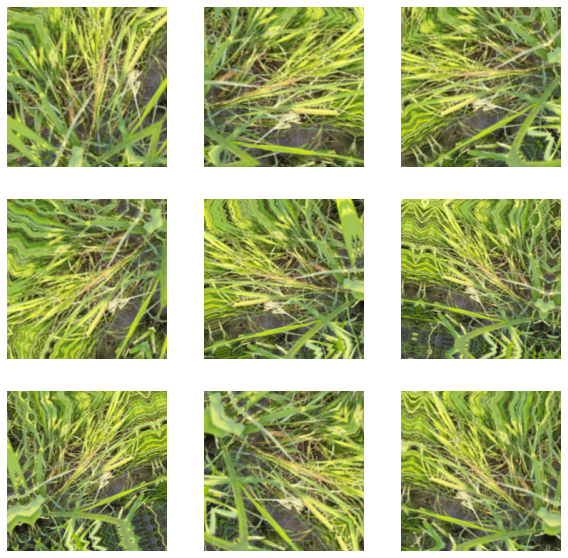

In [ ]:
# Checking augmentation

plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
  for i in range(9):
    augmented_images = augmentation_layer(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
augmented_train_data= train_data.map(
  lambda x, y: (augmentation_layer(x), y))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
augmented_train_data= augmented_train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data= val_data.cache().prefetch(buffer_size=AUTOTUNE)

# DeiT Model

In [ ]:
# Model
MODEL_TYPE = "deit_distilled_tiny_patch16_224"
RESOLUTION = 224
PATCH_SIZE = 16
NUM_PATCHES = (RESOLUTION // PATCH_SIZE) ** 2
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 192
NUM_HEADS = 3
NUM_LAYERS = 12
MLP_UNITS = [
    PROJECTION_DIM * 4,
    PROJECTION_DIM,
]
DROPOUT_RATE = 0.0
DROP_PATH_RATE = 0.1

# Training
NUM_EPOCHS = 20
BASE_LR = 0.0005
WEIGHT_DECAY = 0.0001

# Data
BATCH_SIZE = 128
AUTO = tf.data.AUTOTUNE
NUM_CLASSES = 10

In [ ]:
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=True):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [ ]:
def mlp(x, dropout_rate: float, hidden_units: List):
    """FFN for a Transformer block."""
    # Iterate over the hidden units and
    # add Dense => Dropout.
    for (idx, units) in enumerate(hidden_units):
        x = layers.Dense(
            units,
            activation=tf.nn.gelu if idx == 0 else None,
        )(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


def transformer(drop_prob: float, name: str) -> keras.Model:
    """Transformer block with pre-norm."""
    num_patches = NUM_PATCHES + 2 if "distilled" in MODEL_TYPE else NUM_PATCHES + 1
    encoded_patches = layers.Input((num_patches, PROJECTION_DIM))

    # Layer normalization 1.
    x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(encoded_patches)

    # Multi Head Self Attention layer 1.
    attention_output = layers.MultiHeadAttention(
        num_heads=NUM_HEADS,
        key_dim=PROJECTION_DIM,
        dropout=DROPOUT_RATE,
    )(x1, x1)
    attention_output = (
        StochasticDepth(drop_prob)(attention_output) if drop_prob else attention_output
    )

    # Skip connection 1.
    x2 = layers.Add()([attention_output, encoded_patches])

    # Layer normalization 2.
    x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

    # MLP layer 1.
    x4 = mlp(x3, hidden_units=MLP_UNITS, dropout_rate=DROPOUT_RATE)
    x4 = StochasticDepth(drop_prob)(x4) if drop_prob else x4

    # Skip connection 2.
    outputs = layers.Add()([x2, x4])

    return keras.Model(encoded_patches, outputs, name=name)

In [ ]:
class ViTClassifier(keras.Model):
    """Vision Transformer base class."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # Patchify + linear projection + reshaping.
        self.projection = keras.Sequential(
            [
                layers.Conv2D(
                    filters=PROJECTION_DIM,
                    kernel_size=(PATCH_SIZE, PATCH_SIZE),
                    strides=(PATCH_SIZE, PATCH_SIZE),
                    padding="VALID",
                    name="conv_projection",
                ),
                layers.Reshape(
                    target_shape=(NUM_PATCHES, PROJECTION_DIM),
                    name="flatten_projection",
                ),
            ],
            name="projection",
        )

        # Positional embedding.
        init_shape = (
            1,
            NUM_PATCHES + 1,
            PROJECTION_DIM,
        )
        self.positional_embedding = tf.Variable(
            tf.zeros(init_shape), name="pos_embedding"
        )

        # Transformer blocks.
        dpr = [x for x in tf.linspace(0.0, DROP_PATH_RATE, NUM_LAYERS)]
        self.transformer_blocks = [
            transformer(drop_prob=dpr[i], name=f"transformer_block_{i}")
            for i in range(NUM_LAYERS)
        ]

        # CLS token.
        initial_value = tf.zeros((1, 1, PROJECTION_DIM))
        self.cls_token = tf.Variable(
            initial_value=initial_value, trainable=True, name="cls"
        )

        # Other layers.
        self.dropout = layers.Dropout(DROPOUT_RATE)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        self.head = layers.Dense(
            NUM_CLASSES,
            name="classification_head",
        )

    def call(self, inputs, training=True):
        n = tf.shape(inputs)[0]

        # Create patches and project the patches.
        projected_patches = self.projection(inputs)

        # Append class token if needed.
        cls_token = tf.tile(self.cls_token, (n, 1, 1))
        cls_token = tf.cast(cls_token, projected_patches.dtype)
        projected_patches = tf.concat([cls_token, projected_patches], axis=1)

        # Add positional embeddings to the projected patches.
        encoded_patches = (
            self.positional_embedding + projected_patches
        )  # (B, number_patches, projection_dim)
        encoded_patches = self.dropout(encoded_patches)

        # Iterate over the number of layers and stack up blocks of
        # Transformer.
        for transformer_module in self.transformer_blocks:
            # Add a Transformer block.
            encoded_patches = transformer_module(encoded_patches)

        # Final layer normalization.
        representation = self.layer_norm(encoded_patches)

        # Pool representation.
        encoded_patches = representation[:, 0]

        # Classification head.
        output = self.head(encoded_patches)
        return output

In [ ]:
class ViTDistilled(ViTClassifier):
    def __init__(self, regular_training=False, **kwargs):
        super().__init__(**kwargs)
        self.num_tokens = 2
        self.regular_training = regular_training

        # CLS and distillation tokens, positional embedding.
        init_value = tf.zeros((1, 1, PROJECTION_DIM))
        self.dist_token = tf.Variable(init_value, name="dist_token")
        self.positional_embedding = tf.Variable(
            tf.zeros(
                (
                    1,
                    NUM_PATCHES + self.num_tokens,
                    PROJECTION_DIM,
                )
            ),
            name="pos_embedding",
        )

        # Head layers.
        self.head = layers.Dense(
            NUM_CLASSES,
            name="classification_head",
        )
        self.head_dist = layers.Dense(
            NUM_CLASSES,
            name="distillation_head",
        )

    def call(self, inputs, training=True):
        n = tf.shape(inputs)[0]

        # Create patches and project the patches.
        projected_patches = self.projection(inputs)

        # Append the tokens.
        cls_token = tf.tile(self.cls_token, (n, 1, 1))
        dist_token = tf.tile(self.dist_token, (n, 1, 1))
        cls_token = tf.cast(cls_token, projected_patches.dtype)
        dist_token = tf.cast(dist_token, projected_patches.dtype)
        projected_patches = tf.concat(
            [cls_token, dist_token, projected_patches], axis=1
        )

        # Add positional embeddings to the projected patches.
        encoded_patches = (
            self.positional_embedding + projected_patches
        )  # (B, number_patches, projection_dim)
        encoded_patches = self.dropout(encoded_patches)

        # Iterate over the number of layers and stack up blocks of
        # Transformer.
        for transformer_module in self.transformer_blocks:
            # Add a Transformer block.
            encoded_patches = transformer_module(encoded_patches)

        # Final layer normalization.
        representation = self.layer_norm(encoded_patches)

        # Classification heads.
        x, x_dist = (
            self.head(representation[:, 0]),
            self.head_dist(representation[:, 1]),
        )

        if not training or self.regular_training:
            # During standard train / finetune, inference average the classifier
            # predictions.
            return (x + x_dist) / 2

        elif training:
            # Only return separate classification predictions when training in distilled
            # mode.
            return x, x_dist

In [ ]:
deit_tiny_distilled = ViTDistilled()

dummy_inputs = tf.ones((2, 224, 224, 3))
outputs = deit_tiny_distilled(dummy_inputs, training=False)
print(outputs.shape)

(2, 10)


In [ ]:
class DeiT(keras.Model):
    # Reference:
    # https://keras.io/examples/vision/knowledge_distillation/
    def __init__(self, student, teacher, **kwargs):
        super().__init__(**kwargs)
        self.student = student
        self.teacher = teacher

        self.student_loss_tracker = keras.metrics.Mean(name="student_loss")
        self.dist_loss_tracker = keras.metrics.Mean(name="distillation_loss")

    @property
    def metrics(self):
        metrics = super().metrics
        metrics.append(self.student_loss_tracker)
        metrics.append(self.dist_loss_tracker)
        return metrics

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
    ):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn

    def train_step(self, data):
        # Unpack data.
        x, y = data

        # Forward pass of teacher
        teacher_predictions = tf.nn.softmax(self.teacher(x, training=False), -1)
        teacher_predictions = tf.argmax(teacher_predictions, -1)

        with tf.GradientTape() as tape:
            # Forward pass of student.
            cls_predictions, dist_predictions = self.student(x / 255.0, training=True)

            # Compute losses.
            student_loss = self.student_loss_fn(y, cls_predictions)
            distillation_loss = self.distillation_loss_fn(
                teacher_predictions, dist_predictions
            )
            loss = (student_loss + distillation_loss) / 2

        # Compute gradients.
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights.
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        student_predictions = (cls_predictions + dist_predictions) / 2
        self.compiled_metrics.update_state(y, student_predictions)
        self.dist_loss_tracker.update_state(distillation_loss)
        self.student_loss_tracker.update_state(student_loss)

        # Return a dict of performance.
        results = {m.name: m.result() for m in self.metrics}
        return results

    def test_step(self, data):
        # Unpack the data.
        x, y = data

        # Compute predictions.
        y_prediction = self.student(x / 255.0, training=False)

        # Calculate the loss.
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        self.student_loss_tracker.update_state(student_loss)

        # Return a dict of performance.
        results = {m.name: m.result() for m in self.metrics}
        return results

    def call(self, inputs):
        return self.student(inputs / 255.0, training=False)

In [ ]:
bit_teacher_paddy_doc = keras.models.load_model("/content/drive/MyDrive/thesis/dataset/paddy_doctor/paddy_doctor_3_EfficientNetB4-TF")

In [ ]:
NUM_EPOCHS= 100
BATCH_SIZE= 128

In [ ]:
deit_tiny = ViTDistilled()
deit_distiller = DeiT(student=deit_tiny, teacher= bit_teacher_paddy_doc)

lr_scaled = (BASE_LR / 512) * BATCH_SIZE
deit_distiller.compile(
    optimizer=tfa.optimizers.AdamW(weight_decay=WEIGHT_DECAY, learning_rate=lr_scaled),
    metrics=["accuracy", tfa.metrics.F1Score(average='macro', num_classes= 10)],
    student_loss_fn=keras.losses.CategoricalCrossentropy(
        from_logits=True, label_smoothing=0.1
    ),
    distillation_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
history1 = deit_distiller.fit(augmented_train_data, validation_data=val_data, epochs=NUM_EPOCHS)

Epoch 1/100
74/74 [==============================] - 499s 6s/step - accuracy: 0.1644 - f1_score: 0.0709 - student_loss: 2.2736 - distillation_loss: 2.2203 - val_accuracy: 0.1548 - val_f1_score: 0.0268 - val_student_loss: 2.1956 - val_distillation_loss: 0.0000e+00
Epoch 2/100
74/74 [==============================] - 37s 503ms/step - accuracy: 0.1707 - f1_score: 0.0789 - student_loss: 2.2024 - distillation_loss: 2.1682 - val_accuracy: 0.1548 - val_f1_score: 0.0268 - val_student_loss: 2.1890 - val_distillation_loss: 0.0000e+00
Epoch 3/100
74/74 [==============================] - 37s 503ms/step - accuracy: 0.1971 - f1_score: 0.1005 - student_loss: 2.1781 - distillation_loss: 2.1322 - val_accuracy: 0.1615 - val_f1_score: 0.0356 - val_student_loss: 2.1899 - val_distillation_loss: 0.0000e+00
Epoch 4/100
74/74 [==============================] - 37s 504ms/step - accuracy: 0.2284 - f1_score: 0.1160 - student_loss: 2.1464 - distillation_loss: 2.0935 - val_accuracy: 0.2596 - val_f1_score: 0.1187 -

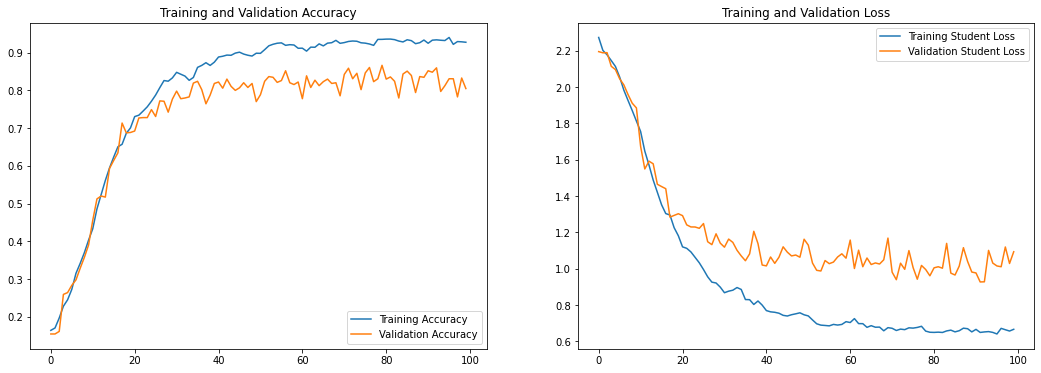

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['student_loss']
val_loss = history1.history['val_student_loss']

epochs_range = range(len(acc))

plt.figure(figsize = (18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Student Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Student Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
history2 = deit_distiller.fit(augmented_train_data, validation_data=val_data, epochs=NUM_EPOCHS)

Epoch 1/100
74/74 [==============================] - 37s 504ms/step - accuracy: 0.9393 - f1_score: 0.9358 - student_loss: 0.6444 - distillation_loss: 0.1772 - val_accuracy: 0.7808 - val_f1_score: 0.7568 - val_student_loss: 1.1704 - val_distillation_loss: 0.0000e+00
Epoch 2/100
74/74 [==============================] - 37s 504ms/step - accuracy: 0.9327 - f1_score: 0.9265 - student_loss: 0.6473 - distillation_loss: 0.1828 - val_accuracy: 0.8183 - val_f1_score: 0.7869 - val_student_loss: 1.0401 - val_distillation_loss: 0.0000e+00
Epoch 3/100
74/74 [==============================] - 37s 504ms/step - accuracy: 0.9236 - f1_score: 0.9178 - student_loss: 0.6685 - distillation_loss: 0.2058 - val_accuracy: 0.8135 - val_f1_score: 0.7968 - val_student_loss: 1.0517 - val_distillation_loss: 0.0000e+00
Epoch 4/100
74/74 [==============================] - 37s 504ms/step - accuracy: 0.9181 - f1_score: 0.9133 - student_loss: 0.6848 - distillation_loss: 0.2298 - val_accuracy: 0.7933 - val_f1_score: 0.7744

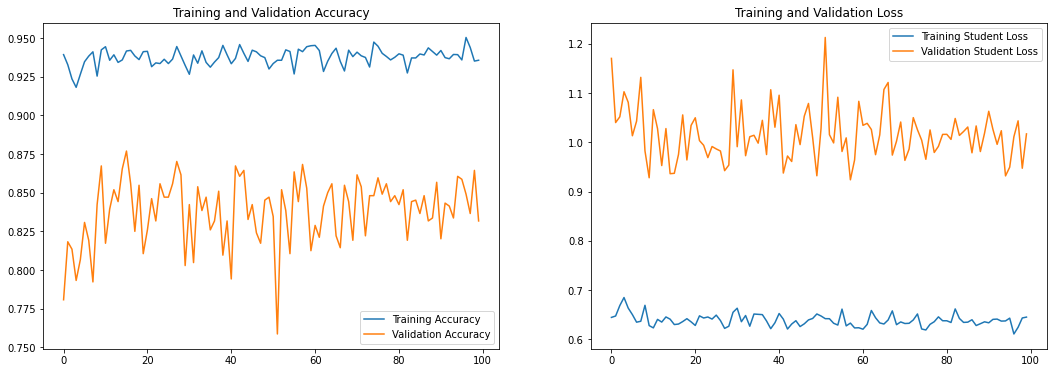

In [ ]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['student_loss']
val_loss = history2.history['val_student_loss']

epochs_range = range(len(acc))

plt.figure(figsize = (18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Student Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Student Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
history3 = deit_distiller.fit(augmented_train_data, validation_data=val_data, epochs=NUM_EPOCHS)

Epoch 1/100
74/74 [==============================] - 37s 503ms/step - accuracy: 0.9341 - f1_score: 0.9275 - student_loss: 0.6490 - distillation_loss: 0.1741 - val_accuracy: 0.8087 - val_f1_score: 0.7851 - val_student_loss: 1.1012 - val_distillation_loss: 0.0000e+00
Epoch 2/100
74/74 [==============================] - 37s 503ms/step - accuracy: 0.9295 - f1_score: 0.9248 - student_loss: 0.6605 - distillation_loss: 0.1847 - val_accuracy: 0.8212 - val_f1_score: 0.7973 - val_student_loss: 1.0644 - val_distillation_loss: 0.0000e+00
Epoch 3/100
74/74 [==============================] - 37s 503ms/step - accuracy: 0.9355 - f1_score: 0.9292 - student_loss: 0.6517 - distillation_loss: 0.1707 - val_accuracy: 0.8077 - val_f1_score: 0.7822 - val_student_loss: 1.1103 - val_distillation_loss: 0.0000e+00
Epoch 4/100
74/74 [==============================] - 37s 503ms/step - accuracy: 0.9390 - f1_score: 0.9334 - student_loss: 0.6456 - distillation_loss: 0.1448 - val_accuracy: 0.7942 - val_f1_score: 0.7676

In [ ]:
import json
with open('/content/drive/MyDrive/thesis/dataset/paddy_doctor/bit_teacher_paddy_doctor1_final/DeiT/history1.json', 'w') as f:
    json.dump(history1.history, f)

In [ ]:
print(f"Number of parameters (millions): {deit_tiny.count_params() / 1e6}.")

Number of parameters (millions): 9.081428.


In [ ]:
print(f"Number of parameters (millions): {bit_teacher_paddy_doc.count_params() / 1e6}.")

Number of parameters (millions): 17.698921.
